# DIVAnd in generalized vertical coordinates



In [1]:
using Pkg
Pkg.status()

Status `C:\Users\jmbeckers\Documents\GitHub\Diva-Workshops\Project.toml`
  [336ed68f] CSV v0.10.9
  [34da2185] Compat v4.6.0
  [efc8151c] DIVAnd v2.7.9
  [864edb3b] DataStructures v0.18.13
  [7073ff75] IJulia v1.24.0
  [a98d9a8b] Interpolations v0.14.7
  [23992714] MAT v0.10.3
  [e1d29d7a] Missings v1.1.0
  [85f8d34a] NCDatasets v0.12.12
  [3725be50] PhysOcean v0.6.7
  [d330b81b] PyPlot v2.11.0
  [f2b01f46] Roots v2.0.8
  [ade2ca70] Dates
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [56ddb016] Logging
  [44cfe95a] Pkg v1.8.0
  [de0858da] Printf
  [9a3f8284] Random
  [10745b16] Statistics
  [8dfed614] Test


In [2]:
#import Pkg; Pkg.add("Roots")
using Roots

### Import packages

In [3]:
using NCDatasets
using DataStructures
using DIVAnd
using Dates
using Statistics
using Random
using Printf
using PyPlot
using Interpolations

## Configuration
* Define the horizontal, vertical (depth levels) and temporal resolutions.
* Select the variable of interest

In [4]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = depthr[1:20];

## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.     
The example is based on a sub-setting of the [Mediterranean Sea](https://www.seadatanet.org/Products#/metadata/cd552057-b604-4004-b838-a4f73cc98fcf) aggregated dataset.      
The dataset has been extracted around the Adriatic Sea and exported to a netCDF using [Ocean Data View](https://odv.awi.de/).
<img src="./Images/MedSeaAggreg.jpg" width="450px">

In [5]:
datadir = "./Adriatic/"
smalldatafile = joinpath(datadir, "AdriaticSea_SDC_1000.nc")
datafile = joinpath(datadir, "AdriaticSea_SDC.nc")
isdir(datadir) ? @info("Directory already created") : mkpath(datadir)

[ Info: Directory already created


Download the data files (test and full) if needed.

In [6]:
if !isfile(smalldatafile)
    @info("Downloading test data file (1000 lines)")
    download("https://dox.ulg.ac.be/index.php/s/1CevuhrnDW18fJT/download", smalldatafile)
else
    @info("Small data file already downloaded")
end

if !isfile(datafile)
    @info("Downloading full data file")
    download("https://dox.ulg.ac.be/index.php/s/IRYJyNZ5KuKVoQL/download", datafile)
else
    @info("Full data file already downloaded")
end

[ Info: Small data file already downloaded
[ Info: Full data file already downloaded


You can try and test first on the small file, this should take less than 10 seconds (the 1st time).

In [7]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, smalldatafile, 
    "Water body salinity");

  6.841082 seconds (7.51 M allocations: 397.933 MiB, 2.95% gc time, 99.36% compilation time)


Then you can read the full file:

In [8]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body salinity");

23140 out of 34709 - 66.66858739808119 %
  3.720572 seconds (673.75 k allocations: 194.677 MiB, 2.96% gc time, 0.87% compilation time)


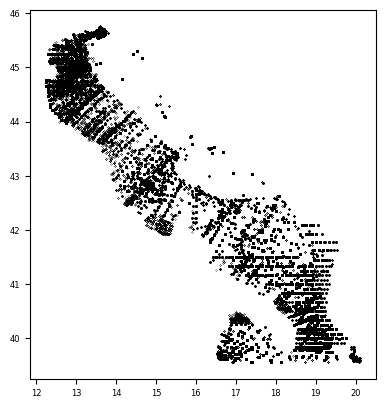

In [9]:
figure("Adriatic-Data")
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1, markerfacecolor="k")
aspectratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)

Check the extremal values of the observations

In [10]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (12.25016975402832, 20.110000610351562)
              minimum and maximum of obs. dimension 2: (39.556758880615234, 45.755001068115234)
              minimum and maximum of obs. dimension 3: (0.0, 1484.2030029296875)
              minimum and maximum of obs. dimension 4: (DateTime("1911-08-17T09:24:00"), DateTime("2015-02-10T10:43:00"))
                          minimum and maximum of data: (4.070000171661377, 40.880001068115234)


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.

In [11]:
bathname = "../data/gebco_30sec_8.nc"
isfile(bathname) ? @info("Bathymetry file already downloaded") : download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathname)

[ Info: Bathymetry file already downloaded


In [12]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  3.620187 seconds (6.79 M allocations: 352.810 MiB, 3.56% gc time, 99.63% compilation time)


sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


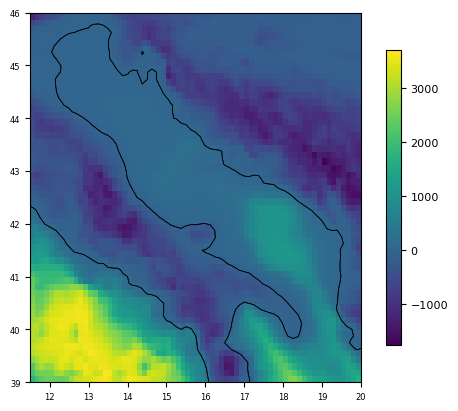

In [13]:
figure("Adriatic-Bathymetry")
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [14]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (69, 57, 20)


(69, 57, 20)

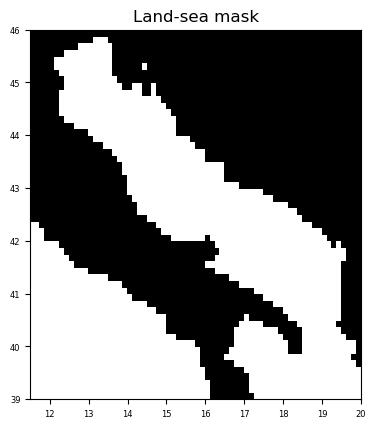

PyObject Text(0.5, 1.0, 'Land-sea mask')

In [15]:
figure("Adriatic-Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, transpose(mask[:,:,1]), cmap=PyPlot.cm.binary_r)
ax.set_title("Land-sea mask")

### 2.3 Edit the mask
As an example we will remove the Tyrrhenian Sea from the domain.

In [16]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [17]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
@show size(mask_edit)

size(mask_edit) = (69, 57, 20)


(69, 57, 20)

In [18]:
#sel = (obslon .<  maximum(bx)) .& (obslon .>  minimum(bx)) .& (obslat .<  maximum(by)) .& (obslat .>  minimum(bx))
#obslon=obslon[sel]
#obslat=obslat[sel]
#obsdepth=obsdepth[sel]
#obsval=obsval[sel]

The edited mask now looks like this:

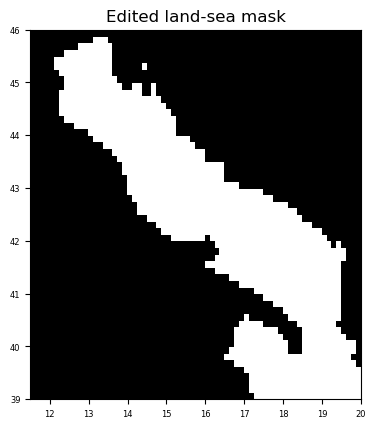

In [19]:
figure("Adriatic-Mask-Edited")
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, mask_edit[:,:,1]', cmap=cmap=PyPlot.cm.binary_r)
ax.set_title("Edited land-sea mask")
gca().set_aspect(aspectratio)

## Define a vertical correlation length function in real space

In [20]:
function Lvert(x,y,z)
    return 5.0 + z/5.0
end

LHOR=2.5

eps2=0.1

iscyclic=falses(3)

3-element BitVector:
 0
 0
 0

## 3. Analysis in Cartesian Coordinates (degrees for simplicity)

In [21]:
xc,yc,zc=ndgrid(lonr,latr,depthr)
pmc = ones(size(xc)) / (xc[2,1,1]-xc[1,1,1]);
pnc = ones(size(xc)) / (yc[1,2,1]-yc[1,1,1]);
poc = ones(size(xc)) / (zc[1,1,2]-zc[1,1,1]);


In [22]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(LHOR,sz)  
leny = lenx./aspectratio
lenz = Lvert.(xc,yc,zc);
@show mean(lenx),mean(leny),mean(lenz)
epsilon2 = eps2;
#epsilon2 = epsilon2 * rdiag;

(mean(lenx), mean(leny), mean(lenz)) = (2.5, 1.8431933420253106, 21.43)


In [23]:
obsval=exp.(-obsdepth./70.0)

1430741-element Vector{Float64}:
 1.0
 0.8668778997501816
 0.751477293075286
 0.6514390575310556
 0.4895416595569531
 0.34251885509304564
 0.2396510364417758
 0.05743261926761735
 0.028115659748972035
 0.013763786733050402
 0.0032985057559390915
 1.0
 0.8668778997501816
 ⋮
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811
 0.9718328750329811

In [24]:
obsmean=mean(obsval)

fi,s=DIVAndrun(mask_edit,(pmc,pnc,poc),(xc,yc,zc),(obslon,obslat,obsdepth),obsval.-obsmean,(lenx,leny,lenz),epsilon2);

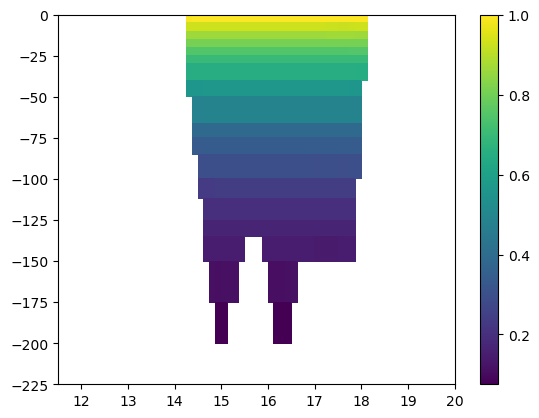

(PyObject <matplotlib.collections.PolyCollection object at 0x000001A244D94FA0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000001A246FCC400>)

In [25]:
jcut=30
pcolor(xc[:,jcut,:],-zc[:,jcut,:],fi[:,jcut,:].+obsmean),colorbar()

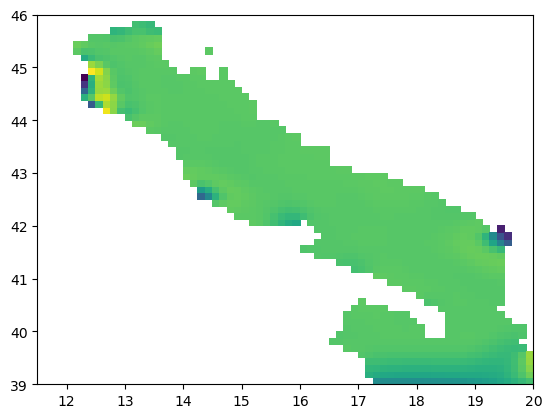

PyObject <matplotlib.collections.PolyCollection object at 0x000001A250465C70>

In [26]:
pcolor(xc[:,:,1],yc[:,:,1],fi[:,:,1])

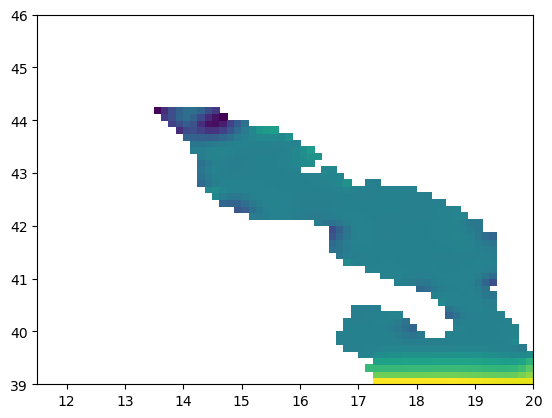

PyObject <matplotlib.collections.PolyCollection object at 0x000001A252EF7850>

In [27]:
kcut=10
pcolor(xc[:,:,kcut],yc[:,:,kcut],fi[:,:,kcut])

In [28]:
@show zc[1,1,kcut]

zc[1, 1, kcut] = 66.0


66.0

# 4.  Coordinate change

In [29]:
Nsigma=25
xs,ys,sigma=ndgrid(lonr,latr,range(0;stop=1,length=Nsigma))
pms = ones(size(xs)) / (xs[2,1,1]-xs[1,1,1]);
pns = ones(size(xs)) / (ys[1,2,1]-ys[1,1,1]);
pos = ones(size(xs)) / (sigma[1,1,2]-sigma[1,1,1]);
sz=size(xs)
masks=trues(size(xs))
masks[:,:,:].=mask_edit[:,:,1]

69×57×25 view(::BitArray{3}, :, :, :) with eltype Bool:
[:, :, 1] =
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  1  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  0  0  1  1  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  1  1  1  1  1  1  1  1  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  0  0

In [30]:

bfun=linear_interpolation((bx,by),b;extrapolation_bc=0.0)



du=2.0
dl=1.0
DG=70
sk=sigma[1,1,2]
skm=sigma[1,1,1]
function betaHB(sigma)
    #if du and dl are zero just return sigma
    return -(tanh((dl+du)*(1.0 - sigma) - dl)+tanh(dl))/(tanh(du)+tanh(dl))+1.0
end

function invbetaHB(beta)
    #if du and dl are zero just return beta
    return 1.0-(atanh(-(beta-1.0)*(tanh(du)+tanh(dl))-tanh(dl))+dl)/(dl+du)
    
end

function alphaHB(x,y)
    alphanum=(betaHB(sk)-betaHB(skm))-DG/max(2.0,bfun(x,y))*(sk-skm)
    alphaden=(betaHB(sk)-betaHB(skm))-(sk-skm)
    alpha=min(alphanum/alphaden,1.0)
    return alpha
end
    
function sigmatoz(x,y,sigma)
    alpha=alphaHB(x,y)
    return  ((1-alpha)*betaHB(sigma)+alpha*sigma)*max(2.0,bfun(x,y))
end
# For more general cases it is easy to make the z(sigma) function more general, but then the inverse will need some
# search of zeros. Needed to get fracional indexes and horizontal plots

function ztosigma(x,y,z)
    gamma=max(min(z/max(2.0,bfun(x,y)),1.0),0)
    alpha=alphaHB(x,y)
    if alpha<0.001 
        return invbetaHB(gamma)
    end
    if alpha>0.999
        return gamma
    end
    guess=alpha*gamma+(1-alpha)*invbetaHB(gamma)
    # now improve by finding zero
    guess=find_zero(x->alpha*x+(1-alpha)*betaHB(x)-gamma, guess)
    return guess
end


ztosigma (generic function with 1 method)

In [31]:
var(invbetaHB.(betaHB.(sigma))-sigma),var(sigma)

(1.6498762222632718e-32, 0.09027869594402183)

In [32]:
#zs=sigmatoz.(xs[:,:,1],ys[:,:,1],Ref(sigma[1,1,:]))
#zs=reshape(reduce(vcat,[zs...]'),size(xs));
@show size(xs),size(ys),size(sigma)
zs=sigmatoz.(xs,ys,sigma)

(size(xs), size(ys), size(sigma)) = ((69, 57, 25), (69, 57, 25), (69, 57, 25))


69×57×25 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

sys:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.


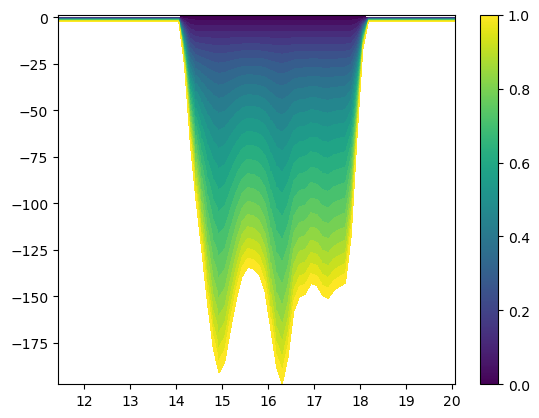

(PyObject <matplotlib.collections.PolyCollection object at 0x000001A252FBF430>, PyObject <matplotlib.colorbar.Colorbar object at 0x000001A25310A5E0>)

In [33]:
jcut=30
pcolor(xs[:,jcut,:],-zs[:,jcut,:],sigma[:,jcut,:],shading="nearest"),colorbar()

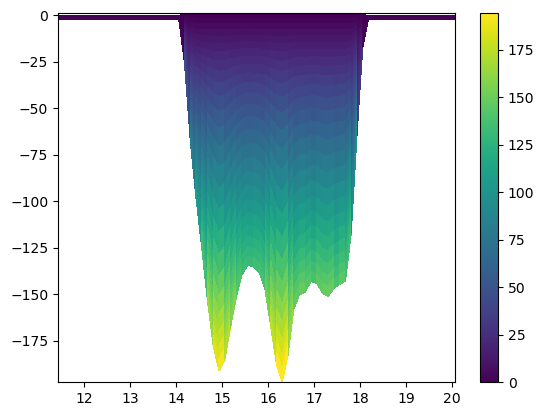

(PyObject <matplotlib.collections.PolyCollection object at 0x000001A25313F460>, PyObject <matplotlib.colorbar.Colorbar object at 0x000001A253249640>)

In [34]:
jcut=30
pcolor(xs[:,jcut,:],-zs[:,jcut,:],zs[:,jcut,:],shading="nearest"),colorbar()

### Vertical position in sigma space

In [35]:
obssigma=ztosigma.(obslon,obslat,obsdepth)

1430741-element Vector{Float64}:
 -2.103526031305176e-16
  0.11973286156943522
  0.19729027317836095
  0.25428893763061555
  0.3371603355069547
  0.4116420093815064
  0.4700267945757994
  0.6442087338311014
  0.7221363253718964
  0.8064714510721009
  1.0
 -2.220446049250313e-16
  0.08463413444712609
  ⋮
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649
  0.014387413716365649

In [36]:
# We already have the z positions of the sigma layers we want to work with from above
# So now just recalculate the metrics:
pozc=deepcopy(pos)
for i = 1:sz[3]
        i0 = max(i - 1, 1)
        i1 = min(i + 1, sz[3])
        pozc[:,:,i].=(i1-i0)./(zs[:,:,i1].-zs[:,:,i0])
end
# Or simpler divide sigma pos  b: No the former is more general in case you have different stretching depending on depth
# pocz=pos./max.(2.0,bfun.(xs,ys));



### Get fractional indexes by working in sigma space:

In [37]:
Igrid = localize_separable_grid((obslon,obslat,obssigma), masks, (xs,ys,sigma), iscyclic)

3×1430741 Matrix{Float64}:
 -1.0  57.928    57.928    57.928    …  61.8532   61.8532   61.8532
 -1.0  12.864    12.864    12.864        9.81424   9.81424   9.81424
 -1.0   3.87359   5.73497   7.10293      1.3453    1.3453    1.3453

In [38]:
masks[:,:,:].=mask_edit[:,:,1]


lenx = fill(LHOR,sz)  
leny = lenx./aspectratio
lenz = Lvert.(xs,ys,zs);

epsilon2 = eps2;
#epsilon2 = epsilon2 * rdiag;
obsmean=mean(obsval)

fi,s=DIVAndrun(masks,(pms,pns,pozc),(xs,ys,zs),(obslon,obslat,obsdepth),obsval.-obsmean,(lenx,leny,lenz),epsilon2;fracindex =Igrid);


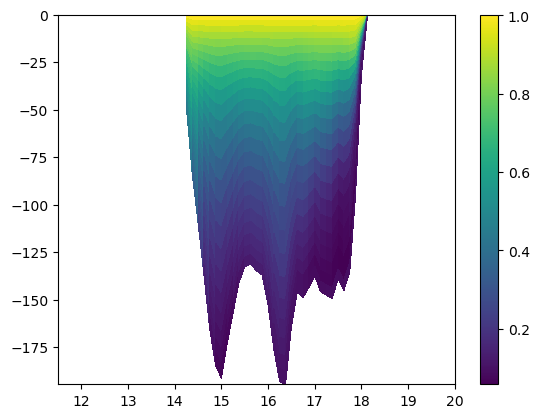

(PyObject <matplotlib.collections.PolyCollection object at 0x000001A251C91CA0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000001A251D2B370>)

In [39]:


jcut=30
pcolor(xs[:,jcut,:],-zs[:,jcut,:],fi[:,jcut,:].+obsmean),colorbar()

## How to make a horizontal plot



In [40]:
zcut=zc[1,1,kcut]
# Create fake data
sigmaonzlevel=ztosigma.(xs[:,:,1],ys[:,:,1],zcut.+ 0.0 .*ys[:,:,1])


Igridcut=localize_separable_grid((xs[:,:,1],ys[:,:,1],sigmaonzlevel), masks, (xs,ys,sigma), )
Htoz, out, outbbox = sparse_interp(masks, Igridcut, iscyclic)

(sparse([10, 10, 11, 11, 12, 12, 13, 13, 14, 14  …  3862, 3863, 3864, 3931, 3932, 3933, 3863, 3864, 3932, 3933], [7876, 7877, 7877, 7878, 7878, 7879, 7879, 7880, 7880, 7881  …  98324, 98324, 98324, 98324, 98324, 98324, 98325, 98325, 98325, 98325], [0.193490324784368, 0.0, 0.20671963513202485, 0.0, 0.29378665519955494, 0.0, 0.2929957785777253, 0.0, 0.3512112229706874, 0.0  …  0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0], 3933, 98325), Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
Htoz=Htoz*sparse_pack(masks)';

In [42]:
zlevelsol=Htoz*statevector_pack(s.sv, (fi,))

3933-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

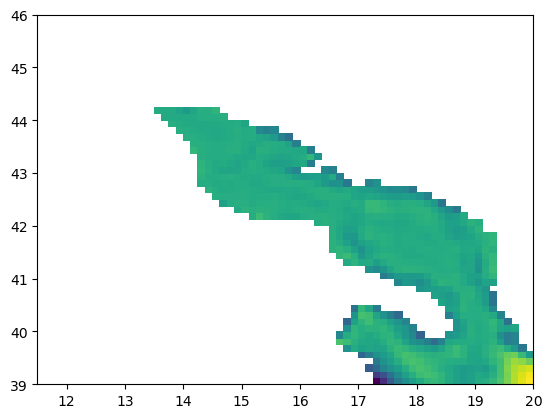

PyObject <matplotlib.collections.PolyCollection object at 0x000001A251D564C0>

In [43]:
soltoplot=reshape(zlevelsol,size(xs)[1:2])
# Need to apply mask because that is not included in the interpolation
soltoplot[zcut.>b].=NaN
soltoplot[mask_edit[:,:,1].==0].=NaN
pcolor(xs[:,:,1],ys[:,:,1],soltoplot.+obsmean)

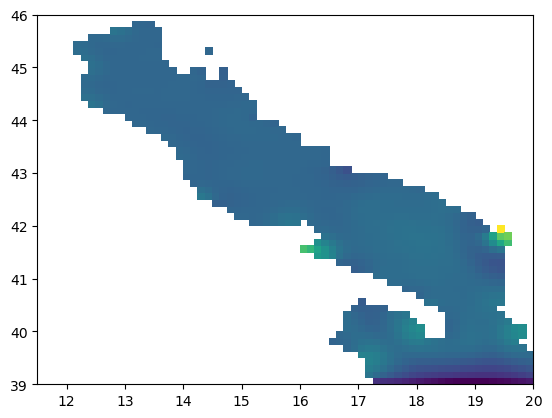

PyObject <matplotlib.collections.PolyCollection object at 0x000001A25041C3A0>

In [44]:
# Surface
pcolor(xs[:,:,1],ys[:,:,1],fi[:,:,1].+obsmean)